# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
from citipy import citipy
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import requests
from pprint import pprint
from api_keys import weather_api_key
import random

In [32]:
def get_random_floats(low, high, k=1):
    """ Return a unique random floats
        in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x=random.uniform(low, high)
        while x in seen:
            x=random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

def get_random_lat():
    return random.uniform(-90, 90)

def get_random_lon():
    return random.uniform(-180, 180)

def generate_city_response(city_name):
    url=f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={weather_api_key}&units=imperial"
    return requests.get(url).json()

def print_city(num,city_name):
    print (f"Processing record {(num+1)%50} of set {round((num+1)/50)+1} | {city_name.capitalize()}")

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

## Generate Cities List

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [11]:
latitudes=get_random_floats(-90,90,500)
longitudes=get_random_floats(-180,180,500)
cities_json=[]
for i in range(500):
    city=citipy.nearest_city(latitudes[i],longitudes[i])
    response_json=generate_city_response(city.city_name)
    while response_json in cities_json:
        city=citipy.nearest_city(get_random_lat(),get_random_lon())       
        response_json=generate_city_response(city.city_name)
    try:
        print_city(i,response_json['name'])
    except KeyError:
        print_city(i,city.city_name)
        print("City not found. Skipping...")
        while response_json.get("name")==None:
            city=citipy.nearest_city(get_random_lat(),get_random_lon())       
            response_json=generate_city_response(city.city_name)
            while response_json in cities_json:
                city=citipy.nearest_city(get_random_lat(),get_random_lon())       
                response_json=generate_city_response(city.city_name)
    
    cities_json.append(response_json)
print("-----------------------------\nData Retrieval Complete      \n-----------------------------")

Processing record 1 of set 1 | Jamestown
Processing record 2 of set 1 | Saldanha
Processing record 3 of set 1 | San jose
Processing record 4 of set 1 | Thompson
Processing record 5 of set 1 | Albany
Processing record 6 of set 1 | Gamba
Processing record 7 of set 1 | Vaini
Processing record 8 of set 1 | Mahébourg
Processing record 9 of set 1 | Cape town
Processing record 10 of set 1 | Portland
Processing record 11 of set 1 | Hamilton
Processing record 12 of set 1 | Tabou
Processing record 13 of set 1 | Cockburn town
Processing record 14 of set 1 | Qasigiannguit
Processing record 15 of set 1 | New norfolk
Processing record 16 of set 1 | Avarua
Processing record 17 of set 1 | Puerto ayora
Processing record 18 of set 1 | Nabire
Processing record 19 of set 1 | Cabo san lucas
Processing record 20 of set 1 | Barentsburg
City not found. Skipping...
Processing record 21 of set 1 | San cristobal
Processing record 22 of set 1 | Santa lucía
Processing record 23 of set 1 | Hobart
Processing record 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [39]:
rows = [[cities_json[i]['name'],cities_json[i]['coord']['lat'],cities_json[i]['coord']['lon'],cities_json[i]['main']['temp_max'],cities_json[i]['main']['humidity'],cities_json[i]['clouds']['all'],cities_json[i]['wind']['speed'],cities_json[i]['sys']['country'],cities_json[i]['dt'] ] for i in range(500)]
df = pd.DataFrame(rows, columns=["City", "Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"])
df.to_csv(r'output_data/weather.txt')
df.head()

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Jamestown,42.0970,-79.2353,76.30,74,1,4.00,US,1626623738
1,Saldanha,-33.0117,17.9442,73.45,63,0,9.01,ZA,1626623738
2,San Jose,37.3394,-121.8950,77.77,63,20,0.00,US,1626623451
3,Thompson,55.7435,-97.8558,50.16,87,90,8.05,CA,1626623738
4,Albany,42.6001,-73.9662,72.75,95,100,4.79,US,1626623723


In [35]:
info=df[["Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Date"]].agg(['count','mean','std','min',q25,q50,q75,'max'])
info

,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,5.000000e+02
mean,20.770883,17.309525,70.624780,68.926000,55.30200,8.155660,1.626624e+09
std,34.297886,91.407396,15.727084,22.290227,38.59396,5.627428,1.003395e+02
min,-54.800000,-179.166700,35.060000,5.000000,0.00000,0.000000,1.626623e+09
q25,-9.035675,-60.040550,57.277500,56.000000,17.75000,4.037500,1.626624e+09
q50,26.642050,21.553050,73.955000,74.000000,61.50000,6.910000,1.626624e+09
q75,50.237575,92.412525,81.870000,86.000000,94.25000,10.875000,1.626624e+09
max,78.218600,179.316700,118.670000,100.000000,100.00000,28.950000,1.626624e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [ ]:
#skipped

In [6]:
#  Get the indices of cities that have humidity over 100%.
#skipped

In [7]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
#skipped

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

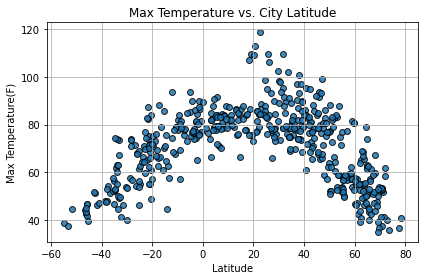

In [66]:
df.plot(kind="scatter",x="Lat",y="Max Temp",title="Max Temperature vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature(F)")
plt.tight_layout()
plt.grid()
plt.savefig("output_data/ Latitude-vs-Temp.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Humidity Plot

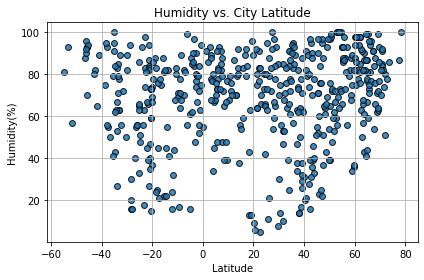

In [67]:
df.plot(kind="scatter",x="Lat",y="Humidity",title="Humidity vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Humidity(%)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Humidity.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Cloudiness Plot

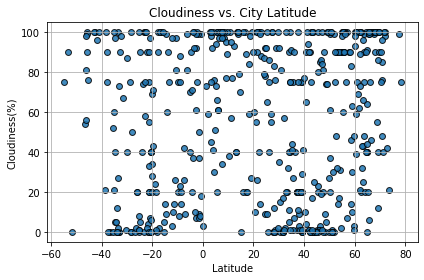

In [68]:
df.plot(kind="scatter",x="Lat",y="Cloudiness",title="Cloudiness vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness(%)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Cloudiness.png", dpi=100, bbox_inches='tight')
plt.show()

## Latitude vs. Wind Speed Plot

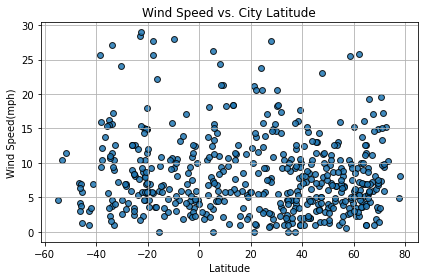

In [69]:
df.plot(kind="scatter",x="Lat",y="Wind Speed",title="Wind Speed vs. City Latitude",edgecolors="black",s=35,alpha=0.85)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed(mph)")
plt.grid()
plt.tight_layout()
plt.savefig("output_data/ Latitude-vs-Wind_Speed.png", dpi=100, bbox_inches='tight')
plt.show()

## Linear Regression

In [86]:
north_df=df.loc[df["Lat"]>0]
south_df=df.loc[df["Lat"]<0]
south_df

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
1,Saldanha,-33.0117,17.9442,73.45,63,0,9.01,ZA,1626623738
5,Gamba,-2.6500,10.0000,74.28,74,7,10.87,GA,1626623739
6,Vaini,-21.2000,-175.2000,73.56,94,20,4.61,TO,1626623739
7,Mahébourg,-20.4081,57.7000,71.89,73,40,14.97,MU,1626623740
8,Cape Town,-33.9258,18.4232,73.81,53,0,11.50,ZA,1626623536
...,...,...,...,...,...,...,...,...,...
476,Hervey Bay,-25.2986,152.8535,54.01,63,1,3.00,AU,1626623999
483,Mwinilunga,-11.7358,24.4293,68.34,32,10,6.20,ZM,1626623960
487,Atambua,-9.1061,124.8925,69.22,78,75,5.23,ID,1626624010
491,Vallenar,-28.5708,-70.7581,70.99,20,100,3.38,CL,1626624013


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

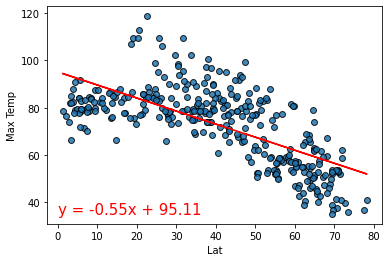

In [87]:
x1=north_df["Lat"]
(slp1,inter1,rvalue1,pvalue1,std1)=linregress(x1,north_df["Max Temp"])
north_df.plot(kind="scatter",x="Lat",y="Max Temp",edgecolors="black",s=35,alpha=0.85)
plt.plot(x1,inter1+slp1*x1,'r-')
line_eq = "y = " + str(round(slp1,2)) + "x + " + str(round(inter1,2))
plt.annotate(line_eq,(0,35),fontsize=15,color="red")
plt.savefig('output_data/Max-temp-vs-North-Lat.png')
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

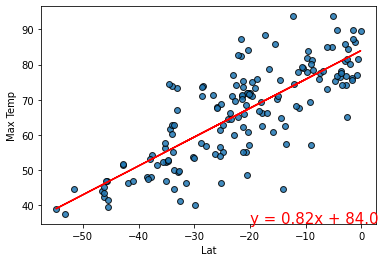

In [93]:
x2=south_df["Lat"]
(slp2,inter2,rvalue2,pvalue2,std2)=linregress(x2,south_df["Max Temp"])
south_df.plot(kind="scatter",x="Lat",y="Max Temp",edgecolors="black",s=35,alpha=0.85)
plt.plot(x2,inter2+slp2*x2,'r-')
line_eq2 = "y = " + str(round(slp2,2)) + "x + " + str(round(inter2,2))
plt.annotate(line_eq2,(-20,35),fontsize=15,color="red")
plt.savefig('output_data/Max-temp-vs-South-Lat.png')
plt.show()
fdasfasdfasd

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression